Loading and processing data

In [25]:
!pip install tensorflow-addons
!pip install tensorflow-io

You should consider upgrading via the 'd:\au\university\3rd semester\very deep\project repo\audioclassification\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\au\university\3rd semester\very deep\project repo\audioclassification\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# This is only needed if the project is run in Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    pass

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive')

[ 100  200  300  400  500  600  700  800  900 1000]
10
[[0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]
(100, 100)


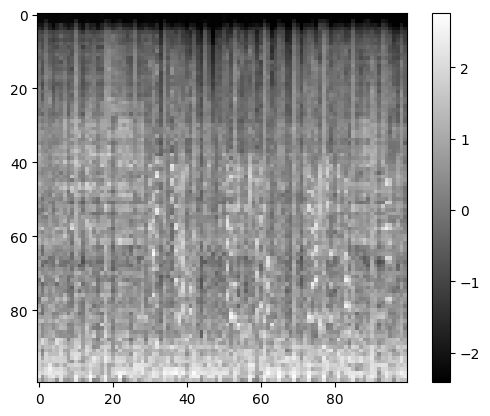

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from help import show_image_from_each_class, label_to_genre, find_genre_indices
import random
import pandas as pd
from sklearn import preprocessing
import cv2
from tqdm import tqdm
# data augmentation
import tensorflow_addons as tfa
import tensorflow_io as tfio
import tensorflow as tf
import numpy as np

# This is only needed if the project is run in Google Colab
try:
    images_original = np.load("/content/drive/MyDrive/images2.npy")
    labels = np.load("/content/drive/MyDrive/labels2.npy")
except FileNotFoundError:
    images_original = np.load("../data/processed/images2.npy")
    labels = np.load("../data/processed/labels2.npy")


genre_indices = find_genre_indices(labels)
print(genre_indices)
print(len(genre_indices))
print(labels[:5])

use_n_genres = 10
images_original = images_original[:genre_indices[use_n_genres-1]]

labels = labels[:genre_indices[use_n_genres-1],:use_n_genres]
input_shape = images_original.shape[1:]
print(input_shape)


scaler = preprocessing.StandardScaler()
images = scaler.fit_transform(images_original.reshape(-1, images_original.shape[-1])).reshape(images_original.shape)
del images_original

images = images.astype(np.double)

plt.imshow(images[60], cmap="gray")
plt.colorbar()
plt.show()


In [27]:
images.shape

(1000, 100, 100)

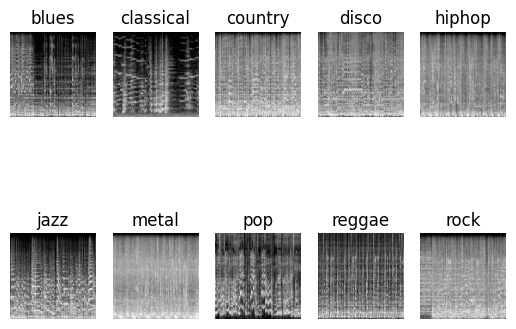

In [28]:
show_image_from_each_class(images, genre_indices, use_n_genres)

In [29]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test set
x_train_simple, x_test, y_train_simple, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=1.0/3)
print("Train set length: " + str(len(x_train_simple)))
print("Validation set length: " + str(len(x_valid)))
print("Test set length: " + str(len(x_test)))



Train set length: 700
Validation set length: 200
Test set length: 100


### Data augmentation

In [30]:
def augmented(images, labels, f, n=2, **kwargs):
    """Apply f to each image n times and return new array
    Labels are repeated to match new augmentation"""
    labels = np.repeat(labels, repeats=n+1, axis=0)
    new_images = np.empty((images.shape[0] * (n + 1), images.shape[1], images.shape[2]))
    i = 0
    for image in tqdm(images):
        new_images[i] = image
        i += 1
        for _ in range(n):
            new_images[i] = f(image, **kwargs)
            i += 1

    return new_images, labels

(2800, 100, 100)


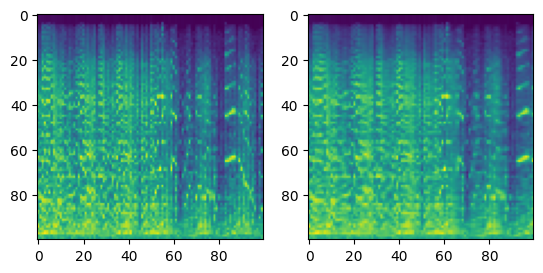

In [31]:
stretch_percentages = [1, 0.9 , 0.8, 0.7]
x_train = np.zeros((x_train_simple.shape[0] * len(stretch_percentages), x_train_simple.shape[1], x_train_simple.shape[2]))
y_train = np.repeat(y_train_simple, repeats=len(stretch_percentages), axis=0)
i = 0

for image in x_train_simple:
    for stretch in stretch_percentages:
        crop = image[:,:int(image.shape[0] * stretch)]
        
        streched = cv2.resize(crop, image.shape)
        x_train[i] = streched
        i += 1

print(x_train.shape)
del x_train_simple
del y_train_simple

n = 2
fig, axs = plt.subplots(1, n)
for i in range(n):
    axs[i].imshow(x_train[i])
plt.show()



In [32]:

def freq_mask_k_times(image_data, param=20, k=2):
    augmented_data = image_data
    for i in range(k):
        augmented_data = tfio.audio.freq_mask(augmented_data, param=param)
    return augmented_data

def time_mask_k_times(image_data, param=20, k=2):
    augmented_data = image_data
    for i in range(k):
        augmented_data = tfio.audio.time_mask(augmented_data, param=param)
    return augmented_data

print(x_train.shape, y_train.shape)
x_train, y_train = augmented(x_train, y_train, f=freq_mask_k_times, n=1)
print("after freq mask", x_train.shape, y_train.shape)
x_train, y_train = augmented(x_train, y_train, f=time_mask_k_times, n=2)
print("after time mask", x_train.shape, y_train.shape)



def warp_image(image_data, W=10):

    # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
    mel_spectrogram = np.reshape(image_data, (-1, image_data.shape[0], image_data.shape[1], 1))
    v, tau = mel_spectrogram.shape[1], mel_spectrogram.shape[2]
    horiz_line_thru_ctr = mel_spectrogram[0][v//2]
    random_pt = horiz_line_thru_ctr[(random.randrange(W, tau - W))] # random point along the horizontal/time axis
    w = np.random.uniform(-W, W) # distance

    # Source Points
    src_points = [[[v//2, random_pt[0]]]]
    
    # Destination Points
    dest_points = [[[v//2, random_pt[0] + w]]]
    mel_spectrogram = mel_spectrogram.astype('float32')
    mel_spectrogram, flowfield = tfa.image.sparse_image_warp(mel_spectrogram, src_points, dest_points, num_boundary_points=2)
    mel_spectrogram = np.squeeze(mel_spectrogram)
    return mel_spectrogram

(2800, 100, 100) (2800, 10)


100%|██████████| 2800/2800 [00:10<00:00, 270.10it/s]


after freq mask (5600, 100, 100) (5600, 10)


100%|██████████| 5600/5600 [01:03<00:00, 87.98it/s] 

after time mask (16800, 100, 100) (16800, 10)


### Describing the model

In [34]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

num_classes = use_n_genres
inputs = Input(shape=(input_shape + (1,)))

# lamda is the weight of the L2 penalty term
lamda = 0.01                  
L2_regularizer = keras.regularizers.l2(lamda)
initializer = tf.keras.initializers.HeNormal()

# So far the best was 16 32 64

# ********************************************* Model ********************************************
# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(3,3), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(inputs)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3,3),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, kernel_size=(3,3),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, kernel_size=(3,3),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(32,kernel_regularizer=L2_regularizer)(encoded)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()
# ********************************************* Model ********************************************

# Best val_acc = 73%, best test_acc = 72%

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_58 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 activation_65 (Activation)  (None, 98, 98, 16)        0         
                                                                 
 batch_normalization_65 (Bat  (None, 98, 98, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 47, 47, 32)        4640

### Dynamic Learning Rate Scheduler

In [35]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(current)
        if len(self.losses) < 5: # We only consider learning rate decrease after 5 epochs since the last decrease.
            print(" lr: {:.6f}".format(lr) )
            return
        if len(self.losses) > 5:
            self.losses.pop(0)
        scheduled_lr = self.schedule(lr,self.losses)
        if lr != scheduled_lr:
            self.losses = [] # We empty the loss array after we decreased the learning rate.
        tf.keras.backend.set_value(self.model.optimizer.lr, 
        scheduled_lr)
        print(" lr: {:.6f}".format(scheduled_lr) )      

def lr_schedule(lr, losses):
    mean = sum(losses[:len(losses)-1]) / len(losses[:len(losses)-1])
    last_loss = losses[-1]
    if last_loss >= mean*0.9: # If there is not at least 10% improvent regarding the mean of the previous losses, than we decrease.
        lr = lr/2
    return lr

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12,restore_best_weights=True)

### Compile and Run The Code

In [53]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.0005, nesterov=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=60,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[CustomLearningRateScheduler(lr_schedule),early_stopping_callback])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2952122688293457
Test accuracy: 0.6800000071525574


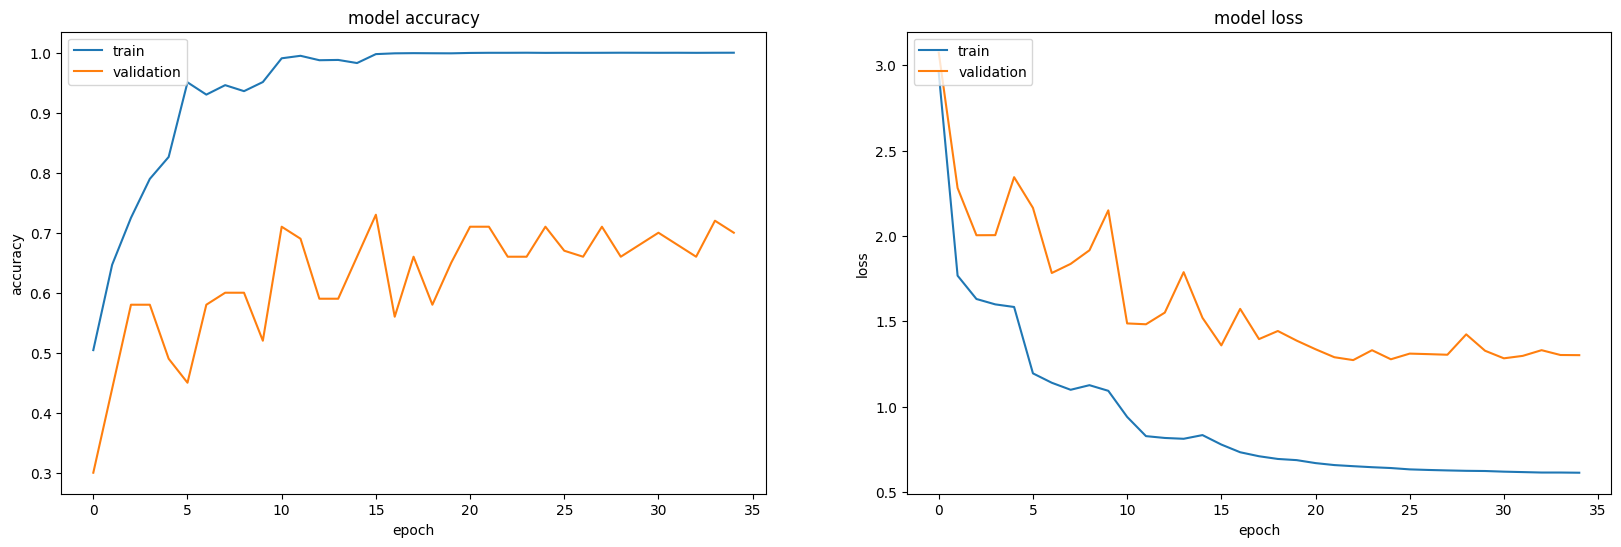

In [57]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

(3, 3, 1, 16)


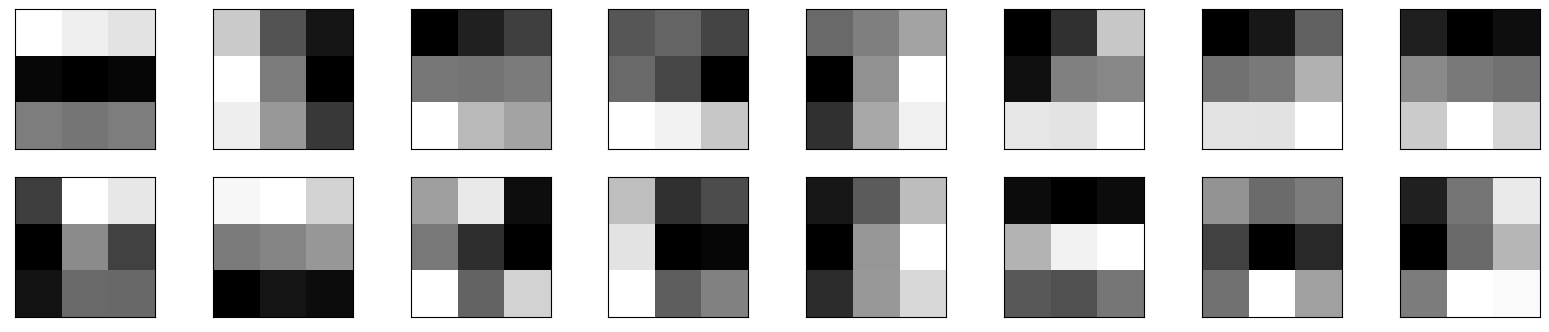

In [58]:
# Displaying the last weights
W = np.asarray(model.layers[1].get_weights()[0])
n_filters = W.shape[3]
print(W.shape)
W = W.reshape((*W.shape[:2], n_filters))
plt.figure(figsize=(20,4))
for i in range(n_filters):
  ax = plt.subplot(2, (n_filters + 1) // 2, i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

In [70]:
predictions = model.predict(x_test)

def top1_error(preds,labels):
    return np.mean(np.argmax(preds,axis=1) != np.argmax(labels,axis=1))

print("Top-1 error is: " + str(top1_error(predictions,y_test[:len(predictions)])))

def top_n_error(preds,labels, n=5):

    wrongs = 0
    for prediction, label in zip(preds, labels):
        top_n = np.flip(np.argsort(prediction))[:n]
        correct = np.argmax(label)

        if correct not in top_n:
            wrongs += 1
    return wrongs / len(preds)

print("Top-5 error is: " + str(top_n_error(predictions,y_test[:len(predictions)], 5)))

4/4 [==============================] - 0s 45ms/step
Top-1 error is: 0.32
Top-5 error is: 0.05


In [60]:
from collections import Counter
pred_counter = Counter(np.argmax(predictions, axis=1))
true_counter = Counter(np.argmax(y_test, axis=1))
print(pred_counter)
print(true_counter)
from help import label_to_genre
def showRandomPredictions(preds,labels):
    maxInd = len(preds)
    print("--------------------------")
    for i in range(5):
        randInd = random.randint(0,maxInd-1)
        onehot = np.zeros(num_classes)
        onehot[np.argmax(preds[randInd])] = 1
        print("Prediction: \t" + str(label_to_genre(list(onehot))))
        print("Label:\t\t" + str(label_to_genre(list(labels[randInd]))))
        print("--------------------------")

showRandomPredictions(predictions,y_test)

Counter({6: 17, 4: 14, 3: 13, 2: 12, 7: 11, 5: 11, 8: 7, 9: 6, 0: 6, 1: 3})
Counter({3: 13, 6: 12, 8: 12, 2: 12, 0: 11, 5: 10, 4: 10, 7: 9, 9: 8, 1: 3})
--------------------------
reggae
Prediction: 	8
reggae
Label:		8
--------------------------
country
Prediction: 	2
country
Label:		2
--------------------------
country
Prediction: 	2
country
Label:		2
--------------------------
hiphop
Prediction: 	4
hiphop
Label:		4
--------------------------
metal
Prediction: 	6
metal
Label:		6
--------------------------


Weights:



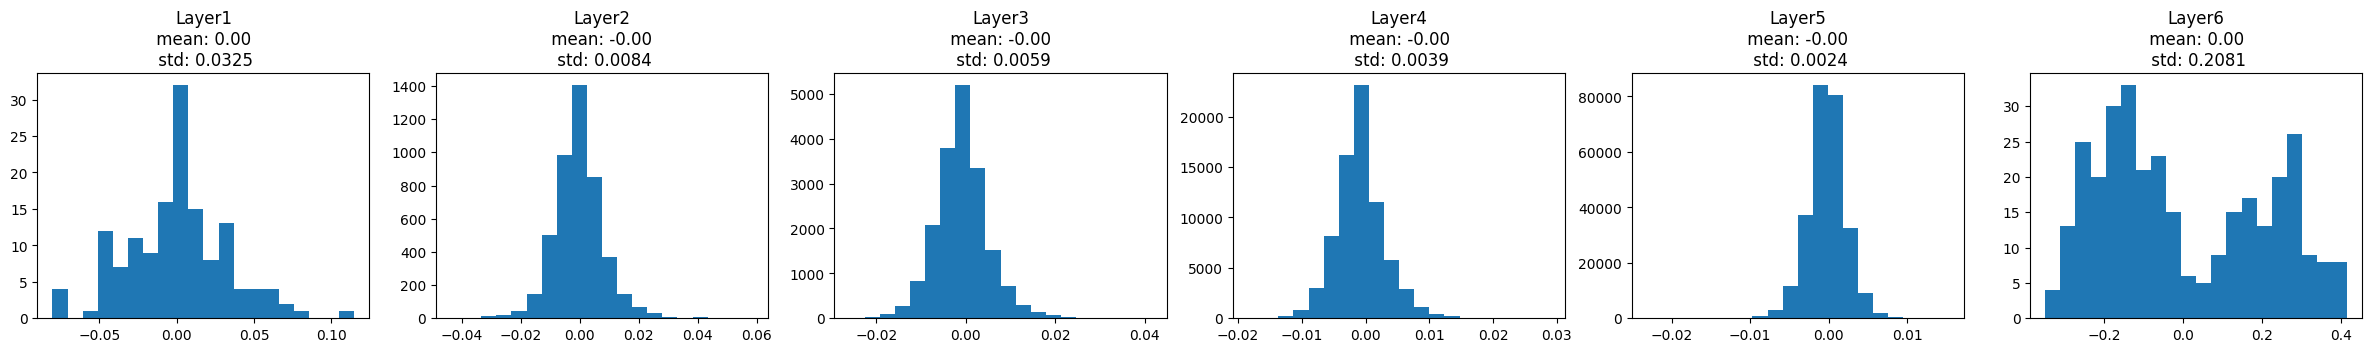

In [68]:
def ShowWeightStats(model):
    print('Weights:\n')
    plt.figure(figsize=(30,7))
    numOfWeightedLayers = 0
    for layer in model.layers:
        if len(layer.get_weights()) != 0 and type(layer) != BatchNormalization:
            numOfWeightedLayers = numOfWeightedLayers+1
    i = 1
    for layer in model.layers:
        if len(layer.get_weights()) != 0 and type(layer) != BatchNormalization:
            w = np.asarray(layer.get_weights()[0]).flatten()
            mean = w.mean()
            std = np.std(w)
            plt.subplot(2,numOfWeightedLayers,i)
            plt.title("Layer" + str(i) + f"\n mean: {mean:.2f} \n std: {std:.4f}")
            plt.hist(w,bins=20)
            i = i + 1
    plt.show()
ShowWeightStats(model)

In [71]:
def CalculatePredStats(predictions,labels):
    success = np.zeros(num_classes)
    count_genres = np.zeros(num_classes)
    for i in range(len(labels)):
        count_genres[np.argmax(labels[i])] = count_genres[np.argmax(labels[i])] + 1
        if labels[i][np.argmax(predictions[i])] == 1:
            success[np.argmax(predictions[i])] = success[np.argmax(predictions[i])] + 1
    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    for i in range(num_classes):
        print(str(genres[i])+ ":    \t{:.0f} \t {:.0f}%".format(success[i],success[i]*100/count_genres[i]))

CalculatePredStats(predictions,y_test)

blues:    	0 	 0%
classical:    	0 	 0%
country:    	0 	 0%
disco:    	0 	 0%
hiphop:    	0 	 0%
jazz:    	0 	 0%
metal:    	0 	 0%
pop:    	0 	 0%
reggae:    	0 	 0%
rock:    	0 	 0%


In [56]:
# The job is done.
model.save('./Model')

INFO:tensorflow:Assets written to: ./Model\assets


INFO:tensorflow:Assets written to: ./Model\assets
